## Cleaning, Merging, and Initial Feature Engineering

In [1]:
# Import libraries 
import pandas as pd

#### Step 1: Load in datasets

In [2]:
spray = pd.read_csv('assets/input/spray.csv')
weather = pd.read_csv('assets/input/weather.csv')
west_nile = pd.read_csv('assets/input/train.csv')
test = pd.read_csv('assets/input/test.csv')

#### Step 2: Clean weather dataset

In [3]:
# Investigate weather
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [4]:
# Inspect number of rows and columns
weather.shape

(2944, 22)

The first step is to examine and handle missing data from weather. According to the data dictionary from NOAA, M represents missing data and T represents trace amounts in the applicable columns. 

In [5]:
# Identify number of missing rows per column
weather[weather=='M'].count()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [6]:
# Water1 appears to have the same number of missing rows are total number of rows
weather['Water1'].unique()

array(['M'], dtype=object)

In [7]:
# Water1 column appears to only have missing values, so we'll drop it
weather = weather.drop('Water1', axis=1)

Next, we'll take a look at all the columns with a substantial number of M's (>1000), as indicated above. This includes Depart, Depth, and SnowFall. We will decide to either keep or drop these columns. 

In [8]:
# Summary of Depart, Depth, and SnowFall column values 
weather[['Depart', 'Depth', 'SnowFall']].describe()

,Depart,Depth,SnowFall
count,2944,2944,2944
unique,42,2,4
top,M,0,M
freq,1472,1472,1472


In [9]:
# Half of the depth data is either missing or 0
weather['Depth'].value_counts()

0    1472
M    1472
Name: Depth, dtype: int64

In [10]:
# 50% of the snowfall values are missing - likely one weather station does not record snowfall 
weather['SnowFall'].value_counts(normalize=True)['M']

0.5

In [11]:
# Drop depth and snowfall columns since they don't appear to have enough useful information
# Drop depart column, as we suspect that absolute temperatures are more important than relative temperatures 
weather.drop(['Depth', 'SnowFall', 'Depart'], axis=1, inplace = True)

Now that we have dropped columns with a significant amount of missing data, we will procede by only cleaning columns that we think we be useful for modeling. We are keeping in mind the theory that West Nile is more likely in hot and dry weather than cold and wet. 

In [12]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [71]:
# Define features by our perception of importance - want to quanitfy temp, humidity, wind, and precipitation
weather_features = ['Station', 'Date', 'Tavg', 'WetBulb', 'PrecipTotal','AvgSpeed']
maybe_features = ['Heat','Cool']

In [14]:
# Investigate good features for further cleaning
weather[weather_features].head()

,Station,Date,Tavg,WetBulb,PrecipTotal,AvgSpeed
0,1,2007-05-01,67,56,0.00,9.2
1,2,2007-05-01,68,57,0.00,9.6
2,1,2007-05-02,51,47,0.00,13.4
3,2,2007-05-02,52,47,0.00,13.4
4,1,2007-05-03,56,48,0.00,11.9


We need to strip spaces from our columns and impute values to 'M' and 'T'. Note,'T' only appears in PrecipTotal. For trace amounts in PrecipTotal, we assume a value of 0.005, which is below the minimum recorded positive amount.  There were only 2 observations of 'M' in PrecipTotal, we assume they are 0.

In [15]:
# Define dataframe that will be used as a mask to update weather later
# Remove spaces before T and M
stripped_weather = weather[weather_features].select_dtypes('object').apply(lambda x: x.str.strip())

In [16]:
# Replace PrecipTotal T and M values 
stripped_weather['PrecipTotal'].replace("T",'0.005',inplace=True)
stripped_weather['PrecipTotal'].replace("M", '0.00',inplace=True)

In [17]:
# Update weather dataframe with new values 
weather['PrecipTotal'] = stripped_weather['PrecipTotal']

In [18]:
# Identify remaining missing values in the features of interest
weather[weather_features][weather[weather_features] == 'M'].count()

Station         0
Date            0
Tavg           11
WetBulb         4
PrecipTotal     0
AvgSpeed        3
dtype: int64

Since there are so few missing values in AvgSpeed and WetBulb, we will drop those rows. We can infer the Tavg from averaging Tmin and Tmax.

In [19]:
# Identify row index and mean values to update Tavg
avgs = weather[['Tmax', 'Tmin']][weather['Tavg']=='M'].mean(axis=1)
weather.loc[avgs.index,'Tavg'] = avgs

In [20]:
# Drop missing rows from avgspeed and wetbulb
mask = (weather['WetBulb'] == 'M') | (weather['AvgSpeed']=='M')
weather.drop(weather.index[mask], inplace=True)

In [21]:
# Convert object dtypes into float
cols = ['Station','Tavg', 'WetBulb', 'PrecipTotal', 'AvgSpeed']
weather[cols] = weather[cols].astype(float)

In [22]:
print(weather[weather_features].shape)
weather[weather_features].head()

(2937, 6)


,Station,Date,Tavg,WetBulb,PrecipTotal,AvgSpeed
0,1.0,2007-05-01,67.0,56.0,0.0,9.2
1,2.0,2007-05-01,68.0,57.0,0.0,9.6
2,1.0,2007-05-02,51.0,47.0,0.0,13.4
3,2.0,2007-05-02,52.0,47.0,0.0,13.4
4,1.0,2007-05-03,56.0,48.0,0.0,11.9


In [23]:
weather['Station'].unique()

array([1., 2.])

In [24]:
weather['latitude'] = weather['Station'].map(lambda x: 41.995 if x == 1.0 else 41.786)

weather['longitude'] = weather['Station'].map(lambda x: -87.933 if x==1.0 else -87.752)

In [25]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,latitude,longitude
0,1.0,2007-05-01,83,50,67.0,51,56.0,0,2,0448,1849,,0.0,29.10,29.82,1.7,27,9.2,41.995,-87.933
1,2.0,2007-05-01,84,52,68.0,51,57.0,0,3,-,-,,0.0,29.18,29.82,2.7,25,9.6,41.786,-87.752
2,1.0,2007-05-02,59,42,51.0,42,47.0,14,0,0447,1850,BR,0.0,29.38,30.09,13.0,4,13.4,41.995,-87.933
3,2.0,2007-05-02,60,43,52.0,42,47.0,13,0,-,-,BR HZ,0.0,29.44,30.08,13.3,2,13.4,41.786,-87.752
4,1.0,2007-05-03,66,46,56.0,40,48.0,9,0,0446,1851,,0.0,29.39,30.12,11.7,7,11.9,41.995,-87.933


## Cleaning west_nile and test dataframes

In [26]:
west_nile.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [27]:
west_nile.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [70]:
# Picking promising columns to clean.  TODO: finish selection
west_nile_features = ['Date','Species','Longitude', 'Latitude']
target = ['WnvPresent']

In [42]:
west_nile[west_nile_features].isna().sum()

Date            0
Species         0
NumMosquitos    0
Longitude       0
Latitude        0
dtype: int64

In [43]:
west_nile[west_nile_features].dtypes

Date             object
Species          object
NumMosquitos      int64
Longitude       float64
Latitude        float64
dtype: object

In [47]:
# Species has a number of levels--we'll only care about some.  There's also a dual feature
# that we'll need to account for--Pipiens/Restuans should count as both a Pipiens and a Restuans.
west_nile['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [51]:
west_nile.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
Station                   float64
dtype: object

In [56]:
west_nile.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station'],
      dtype='object')

In [52]:
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [54]:
test.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [59]:
test[west_nile_features]

,Date,Species,Longitude,Latitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,-87.800991,41.954690
1,2008-06-11,CULEX RESTUANS,-87.800991,41.954690
2,2008-06-11,CULEX PIPIENS,-87.800991,41.954690
3,2008-06-11,CULEX SALINARIUS,-87.800991,41.954690
4,2008-06-11,CULEX TERRITANS,-87.800991,41.954690
5,2008-06-11,CULEX TARSALIS,-87.800991,41.954690
6,2008-06-11,UNSPECIFIED CULEX,-87.800991,41.954690
7,2008-06-11,CULEX ERRATICUS,-87.800991,41.954690
8,2008-06-11,CULEX PIPIENS/RESTUANS,-87.769279,41.994991
9,2008-06-11,CULEX RESTUANS,-87.769279,41.994991


## Spray data


In [64]:
spray.shape

(14835, 4)

In [73]:
spray['Date'].map(lambda x: x[:4]).unique()

array(['2011', '2013'], dtype=object)

In [60]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [67]:
# There is no time data for mosquito measurement, so we have nothing to compare spray times to.
spray_features = ['Date', 'Latitude', 'Longitude']

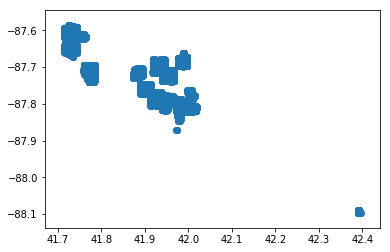

In [68]:
# Look at our spray lat/long info
import matplotlib.pyplot as plt

plt.scatter(spray['Latitude'], spray['Longitude'])

In [61]:
#
spray.isna().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [95]:
# Since there's no overlap in year between our test data and our spray data,
# we'll omit spray data from our model.  We'll probably incorporate it
# into our cost-benefit analysis after model selection is complete.
test.Date.map(lambda x: x[:4]).unique()

array(['2008', '2010', '2012', '2014'], dtype=object)

#### Merging Dataframes

In [74]:
# Make a "nearest station" feature in west_nile dataframe in order to merge weather and west_nile
def distance(lat1, long1, lat2, long2):
    return np.sqrt((lat1 - lat2)**2 + (long1-long2)**2)

In [75]:
def closest_station(lat, long):
    lat_1, long_1 = 41.995, -87.933
    lat_2, long_2 = 41.786, -87.752
    if distance(lat, long, lat_1, long_1) < distance(lat, long, lat_2, long_2):
        return 1.0
    else:
        return 2.0

In [76]:
# test function
closest_station(41.954690, -87.800991)

1.0

In [77]:
west_nile['Station'] = west_nile.apply(lambda x: closest_station(x['Latitude'], x['Longitude']),axis=1)

In [78]:
west_nile['Station'].value_counts()

2.0    8245
1.0    2261
Name: Station, dtype: int64

In [85]:
west_nile.shape

(10506, 13)

In [86]:
weather.shape

(2937, 20)

In [92]:
# We're doing an inner join here for computational ease.  The most robust approach would
# impute missing weather values to observations in west_nile whose dates don't appear
# in the weather data.
combined = pd.merge(west_nile,weather,how='inner', on = ['Date', 'Station'])
combined.shape

(10480, 31)

In [103]:
west_nile_features.extend(weather_features)
west_nile_features.extend(target)

In [105]:
combined[west_nile_features].to_csv('combined.csv',index=False)